# Loan Approval Prediction

* person_age:	Age of the person
* person_gender:	Gender of the person
* person_education:	Highest education level
* person_income:	Annual income
* person_emp_exp:	Years of employment experience
* person_home_ownership:	Home ownership status (e.g., rent, own, mortgage)
* loan_amnt:	Loan amount requested
* loan_intent:	Purpose of the loan
* loan_int_rate:	Loan interest rate
* loan_percent_income:	Loan amount as a percentage of annual income
* cb_person_cred_hist_length:	Length of credit history in years
* credit_score:	Credit score of the person
* previous_loan_defaults_on_file:	Indicator of previous loan defaults
* loan_status: (target variable)	Loan approval status: 1 = approved; 0 = rejected

# Importing Libraries and Dataset

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_validate, train_test_split
from matplotlib import rc,rcParams
import itertools
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f'%x)

In [2]:
df_ = pd.read_csv('loan_data.csv')
df = df_.copy()
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.00,female,Master,71948.00,0,RENT,35000.00,PERSONAL,16.02,0.49,3.00,561,No,1
1,21.00,female,High School,12282.00,0,OWN,1000.00,EDUCATION,11.14,0.08,2.00,504,Yes,0
2,25.00,female,High School,12438.00,3,MORTGAGE,5500.00,MEDICAL,12.87,0.44,3.00,635,No,1
3,23.00,female,Bachelor,79753.00,0,RENT,35000.00,MEDICAL,15.23,0.44,2.00,675,No,1
4,24.00,male,Master,66135.00,1,RENT,35000.00,MEDICAL,14.27,0.53,4.00,586,No,1


In [3]:
df.isna().sum().sum()

0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,45000.00,27.76,6.05,20.00,24.00,26.00,30.00,144.00
person_income,45000.00,80319.05,80422.50,8000.00,47204.00,67048.00,95789.25,7200766.00
person_emp_exp,45000.00,5.41,6.06,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.00,9583.16,6314.89,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.00,11.01,2.98,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.00,0.14,0.09,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.00,5.87,3.88,2.00,3.00,4.00,8.00,30.00
credit_score,45000.00,632.61,50.44,390.00,601.00,640.00,670.00,850.00
loan_status,45000.00,0.22,0.42,0.00,0.00,0.00,0.00,1.00


## Grapping Categorical and Numerical Variables

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    #Categorical Columns
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != 'O' and
                   dataframe[col].nunique() < cat_th]
    cat_but_car= [col for col in dataframe.columns if dataframe[col].dtypes=='O' and
              dataframe[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #Numerical Columns
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes!='O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Dataset Information
    print(f"Observation: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"Categorical Columns: {len(cat_cols)}")
    print(f"Numerical Columns: {len(num_cols)}")
    print(f"Categorical But Cardinal: {len(cat_but_car)}")
    print(f"Numerical But Categorical: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car  =grab_col_names(df)

Observation: 45000
Variables: 14
Categorical Columns: 6
Numerical Columns: 8
Categorical But Cardinal: 0
Numerical But Categorical: 1


## Explorer Data Analysis

################# PERSON_GENDER ##################
               person_gender  Ratio
person_gender                      
male                   24841  55.20
female                 20159  44.80
##################################################


<ipython-input-7-05b1ff88eda8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette='Accent')


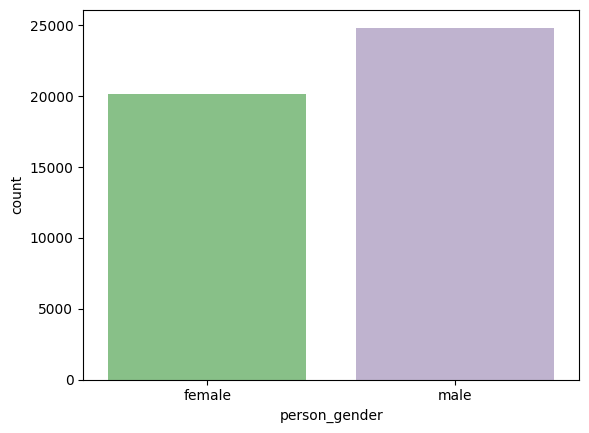

################ PERSON_EDUCATION ################
                  person_education  Ratio
person_education                         
Bachelor                     13399  29.78
Associate                    12028  26.73
High School                  11972  26.60
Master                        6980  15.51
Doctorate                      621   1.38
##################################################


<ipython-input-7-05b1ff88eda8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette='Accent')


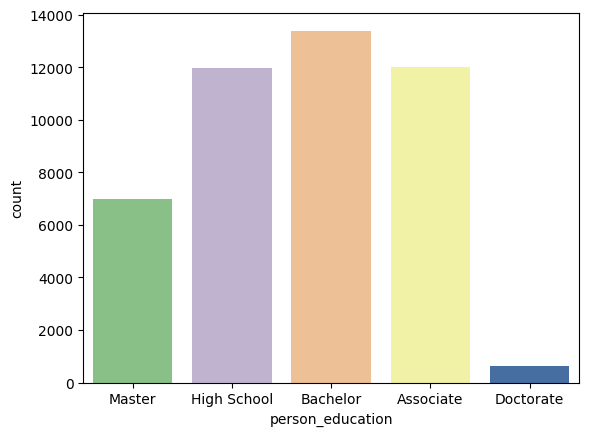

############# PERSON_HOME_OWNERSHIP ##############
                       person_home_ownership  Ratio
person_home_ownership                              
RENT                                   23443  52.10
MORTGAGE                               18489  41.09
OWN                                     2951   6.56
OTHER                                    117   0.26
##################################################


<ipython-input-7-05b1ff88eda8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette='Accent')


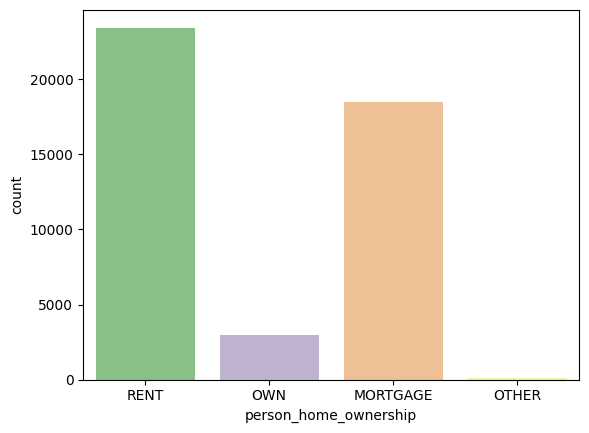

################## LOAN_INTENT ###################
                   loan_intent  Ratio
loan_intent                          
EDUCATION                 9153  20.34
MEDICAL                   8548  19.00
VENTURE                   7819  17.38
PERSONAL                  7552  16.78
DEBTCONSOLIDATION         7145  15.88
HOMEIMPROVEMENT           4783  10.63
##################################################


<ipython-input-7-05b1ff88eda8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette='Accent')


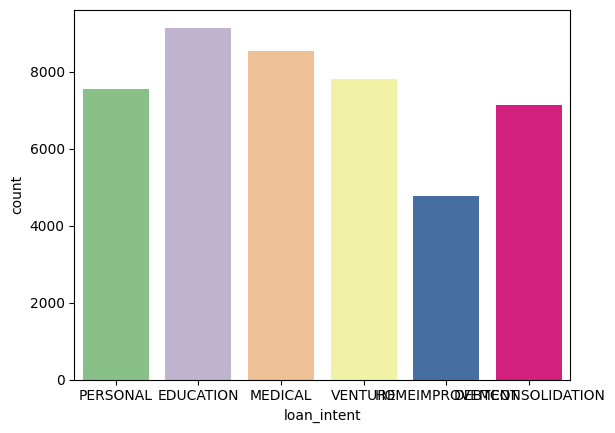

######### PREVIOUS_LOAN_DEFAULTS_ON_FILE #########
                                previous_loan_defaults_on_file  Ratio
previous_loan_defaults_on_file                                       
Yes                                                      22858  50.80
No                                                       22142  49.20
##################################################


<ipython-input-7-05b1ff88eda8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette='Accent')


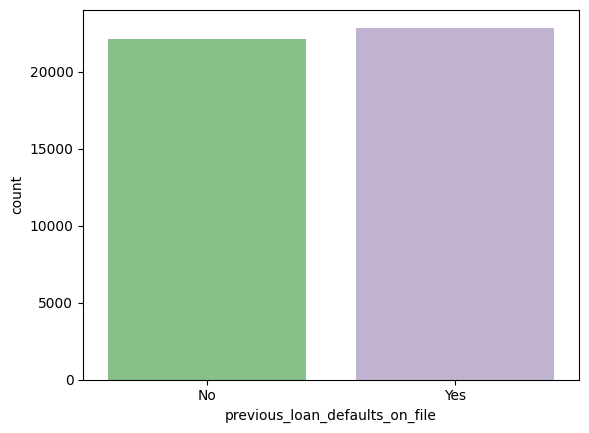

################## LOAN_STATUS ###################
             loan_status  Ratio
loan_status                    
0                  35000  77.78
1                  10000  22.22
##################################################


<ipython-input-7-05b1ff88eda8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette='Accent')


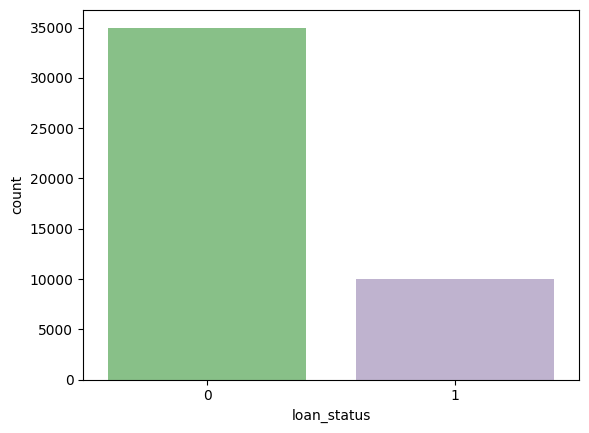

In [7]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("#"*50)
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe, palette='Accent')
        plt.show()

for i in cat_cols:
    print((' '+i.upper()+' ').center(50,'#'))
    cat_summary(df,i,plot=True)

count   45000.00
mean       27.76
std         6.05
min        20.00
5%         22.00
10%        22.00
25%        24.00
40%        25.00
50%        26.00
60%        27.00
75%        30.00
90%        35.00
95%        39.00
max       144.00
Name: person_age, dtype: float64


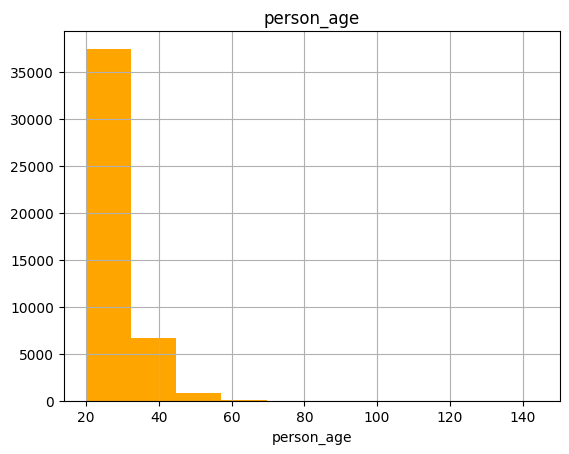

count     45000.00
mean      80319.05
std       80422.50
min        8000.00
5%        28366.70
10%       35118.90
25%       47204.00
40%       59456.00
50%       67048.00
60%       76436.80
75%       95789.25
90%      133276.10
95%      166754.70
max     7200766.00
Name: person_income, dtype: float64


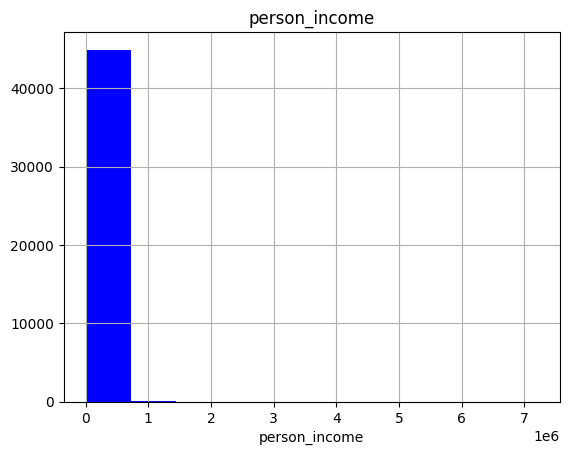

count   45000.00
mean        5.41
std         6.06
min         0.00
5%          0.00
10%         0.00
25%         1.00
40%         3.00
50%         4.00
60%         5.00
75%         8.00
90%        13.00
95%        17.00
max       125.00
Name: person_emp_exp, dtype: float64


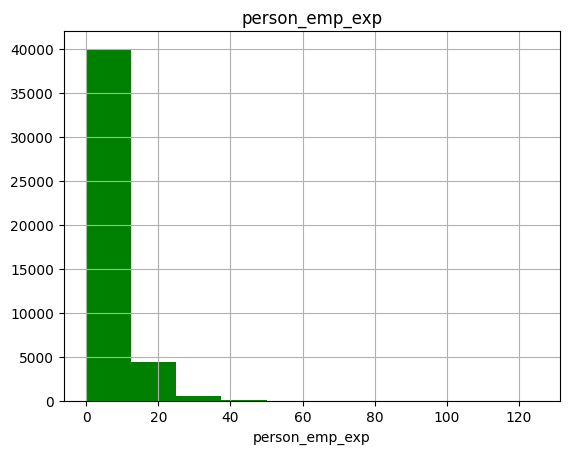

count   45000.00
mean     9583.16
std      6314.89
min       500.00
5%       2000.00
10%      3000.00
25%      5000.00
40%      6600.00
50%      8000.00
60%     10000.00
75%     12237.25
90%     19200.00
95%     24000.00
max     35000.00
Name: loan_amnt, dtype: float64


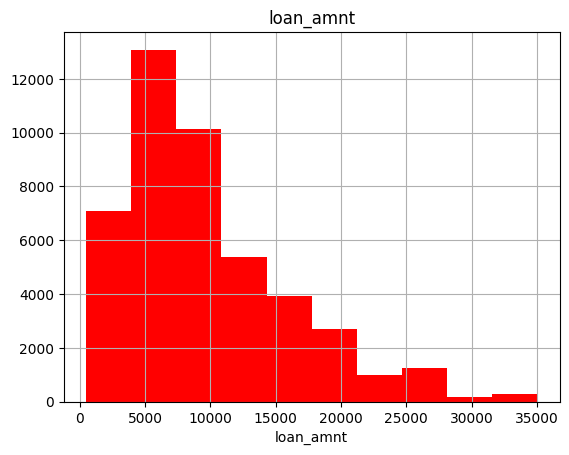

count   45000.00
mean       11.01
std         2.98
min         5.42
5%          6.17
10%         6.99
25%         8.59
40%        10.58
50%        11.01
60%        11.49
75%        12.99
90%        14.97
95%        16.00
max        20.00
Name: loan_int_rate, dtype: float64


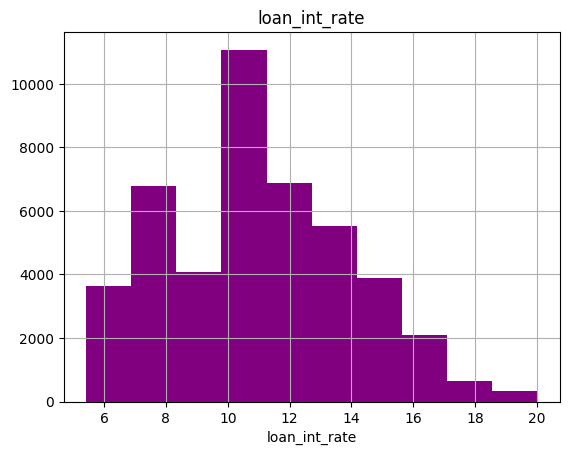

count   45000.00
mean        0.14
std         0.09
min         0.00
5%          0.03
10%         0.04
25%         0.07
40%         0.10
50%         0.12
60%         0.14
75%         0.19
90%         0.26
95%         0.31
max         0.66
Name: loan_percent_income, dtype: float64


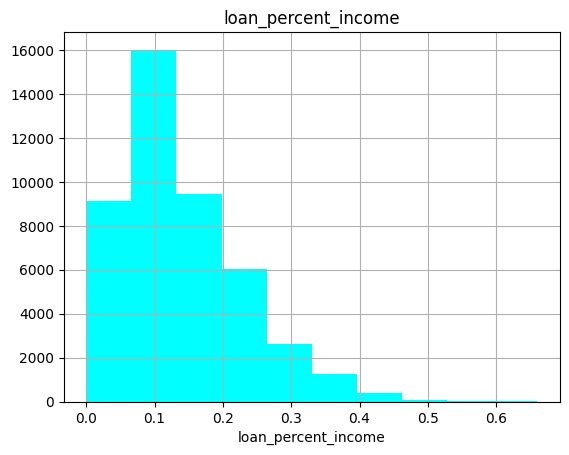

count   45000.00
mean        5.87
std         3.88
min         2.00
5%          2.00
10%         2.00
25%         3.00
40%         4.00
50%         4.00
60%         6.00
75%         8.00
90%        11.00
95%        14.00
max        30.00
Name: cb_person_cred_hist_length, dtype: float64


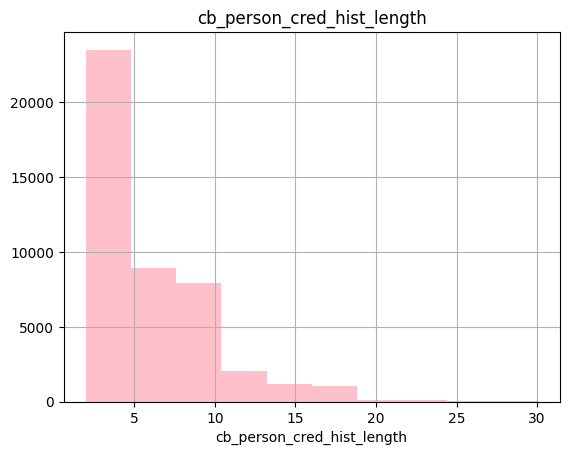

count   45000.00
mean      632.61
std        50.44
min       390.00
5%        539.00
10%       563.00
25%       601.00
40%       626.00
50%       640.00
60%       652.00
75%       670.00
90%       692.00
95%       703.00
max       850.00
Name: credit_score, dtype: float64


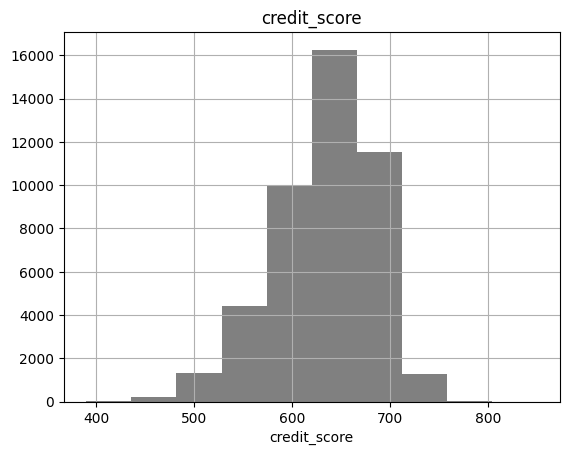

In [8]:
def num_summary(dataframe, col, plot=False,color='orange'):
    quantiles= [0.05, 0.10, 0.25, 0.40, 0.60, 0.75, 0.90, 0.95]
    print(dataframe[col].describe(quantiles).T)
    if plot:
        dataframe[col].hist(bins=10, color=color)
        plt.xlabel(col)
        plt.title(col)
        plt.show()

colors = ['orange', 'blue', 'green', 'red', 'purple', 'cyan', 'pink', 'gray', 'brown']
for i, col in enumerate(num_cols):
    num_summary(df, col, plot=True, color= colors[i % len(colors)])

## Analysis of Variables by Target

### Categorical Columns

In [9]:
def target_with_cat(dataframe, cat_col, target):
    print(pd.DataFrame({'Target Mean:':dataframe.groupby(cat_col)[target].mean(),
                        'Count': dataframe[cat_col].value_counts(),
                        'Ratio':dataframe[cat_col].value_counts() / len(dataframe)*100}))
    print()

for col in cat_cols:
    target_with_cat(df, col, 'loan_status')

               Target Mean:  Count  Ratio
person_gender                            
female                 0.22  20159  44.80
male                   0.22  24841  55.20

                  Target Mean:  Count  Ratio
person_education                            
Associate                 0.22  12028  26.73
Bachelor                  0.23  13399  29.78
Doctorate                 0.23    621   1.38
High School               0.22  11972  26.60
Master                    0.22   6980  15.51

                       Target Mean:  Count  Ratio
person_home_ownership                            
MORTGAGE                       0.12  18489  41.09
OTHER                          0.33    117   0.26
OWN                            0.08   2951   6.56
RENT                           0.32  23443  52.10

                   Target Mean:  Count  Ratio
loan_intent                                  
DEBTCONSOLIDATION          0.30   7145  15.88
EDUCATION                  0.17   9153  20.34
HOMEIMPROVEMENT            0.2

### Numerical Columns

In [10]:
def target_with_num(dataframe, num_col, target):
    print(num_col.capitalize())
    print(dataframe.groupby(target)[num_col].mean(), end='\n\n')

for col in num_cols:
    target_with_num(df, col, 'loan_status')

Person_age
loan_status
0   27.83
1   27.52
Name: person_age, dtype: float64

Person_income
loan_status
0   86157.04
1   59886.10
Name: person_income, dtype: float64

Person_emp_exp
loan_status
0   5.48
1   5.18
Name: person_emp_exp, dtype: float64

Loan_amnt
loan_status
0    9219.58
1   10855.69
Name: loan_amnt, dtype: float64

Loan_int_rate
loan_status
0   10.48
1   12.86
Name: loan_int_rate, dtype: float64

Loan_percent_income
loan_status
0   0.12
1   0.20
Name: loan_percent_income, dtype: float64

Cb_person_cred_hist_length
loan_status
0   5.90
1   5.76
Name: cb_person_cred_hist_length, dtype: float64

Credit_score
loan_status
0   632.81
1   631.89
Name: credit_score, dtype: float64



## Outliers Problem

In [11]:
def outlier_thresholds(dataframe, col_name,  q1=0.05, q3=0.95):
    Q1 = dataframe[col_name].quantile(q1)
    Q3 = dataframe[col_name].quantile(q3)
    IQR = Q3 - Q1
    low = Q1 - 1.5*IQR
    up = Q3 + 1.5*IQR
    return low, up

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].shape[0] > 10:
      print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].head(10))
    else:
      print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )])
    if index:
      outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].index
      return outlier_index

number =1
for col in num_cols:
    print(number, '.', col.upper(), end='\n\n')
    grab_outliers(df, col)
    print()
    number += 1

1 . PERSON_AGE

       person_age person_gender person_education  person_income  person_emp_exp person_home_ownership  loan_amnt        loan_intent  loan_int_rate  loan_percent_income  cb_person_cred_hist_length  credit_score previous_loan_defaults_on_file  loan_status
81         144.00          male         Bachelor      300616.00             125                  RENT    4800.00            VENTURE          13.57                 0.02                        3.00           789                             No            0
183        144.00          male        Associate      241424.00             121              MORTGAGE    6000.00          EDUCATION          11.86                 0.02                        2.00           807                             No            0
575        123.00        female      High School       97140.00             101                  RENT   20400.00          EDUCATION          10.25                 0.21                        3.00           805             

### Re-assignment with Thresholds

In [12]:
def replace_with_thresholds(dataframe, col):
    low, up = outlier_thresholds(dataframe,col)
    dataframe.loc[dataframe[col] < low, col] = low
    dataframe.loc[dataframe[col] > up, col] = up

replace_with_thresholds(df,"person_age")
replace_with_thresholds(df,"person_income")
replace_with_thresholds(df,"person_emp_exp")

<ipython-input-12-ed30d76ef153>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-25.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[dataframe[col] < low, col] = low


## Corelation Matrix

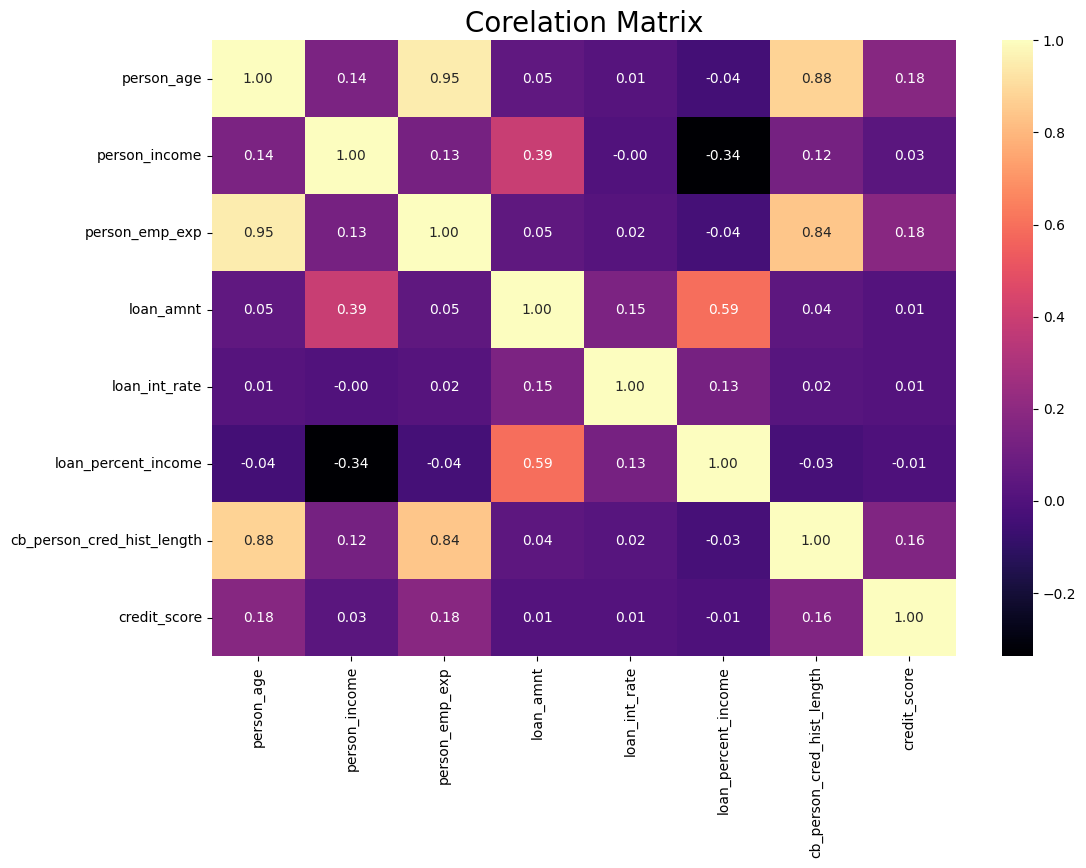

In [13]:
f, ax = plt.subplots(figsize=[12,8])
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', ax=ax, cmap='magma')
ax.set_title('Corelation Matrix', fontsize=20)
plt.show()

## Encoding

### Label Encoding

In [14]:
df['person_education'].value_counts()

,count
person_education,
Bachelor,13399
Associate,12028
High School,11972
Master,6980
Doctorate,621


In [15]:
education_mapping = {'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4}
df['Education_encoded'] = df['person_education'].map(education_mapping)

### One-Hot Encoding

In [16]:
cat_cols = [col for col in cat_cols if col != 'loan_status']

In [17]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

## Scaling

In [18]:
rob_scaler = RobustScaler()
df_scaled = rob_scaler.fit_transform(df[num_cols])
df[num_cols] =pd.DataFrame(df_scaled, columns=df[num_cols].columns)
df.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,Education_encoded,person_gender_male,person_education_Bachelor,person_education_Doctorate,person_education_High School,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
0,-0.67,0.10,-0.57,3.73,1.14,3.08,-0.20,-1.14,1,3,False,False,False,False,True,False,False,True,False,False,False,True,False,False
1,-0.83,-1.13,-0.57,-0.97,0.03,-0.33,-0.40,-1.97,0,0,False,False,False,True,False,False,True,False,True,False,False,False,False,True
2,-0.17,-1.12,-0.14,-0.35,0.42,2.67,-0.20,-0.07,1,0,False,False,False,True,False,False,False,False,False,False,True,False,False,False
3,-0.50,0.26,-0.57,3.73,0.96,2.67,-0.40,0.51,1,2,False,True,False,False,False,False,False,True,False,False,True,False,False,False
4,-0.33,-0.02,-0.43,3.73,0.74,3.42,0.00,-0.78,1,3,True,False,False,False,True,False,False,True,False,False,True,False,False,False


# Base Model

In [19]:
X =df.drop('loan_status',axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Roc-Auc Score: {roc_auc_score(y_test, y_pred)}")

Accuracy: 0.8951111111111111
Precision: 0.777315296566077
Recall: 0.7432835820895523
F1 Score: 0.7599186164801628
Roc-Auc Score: 0.8410266265240323


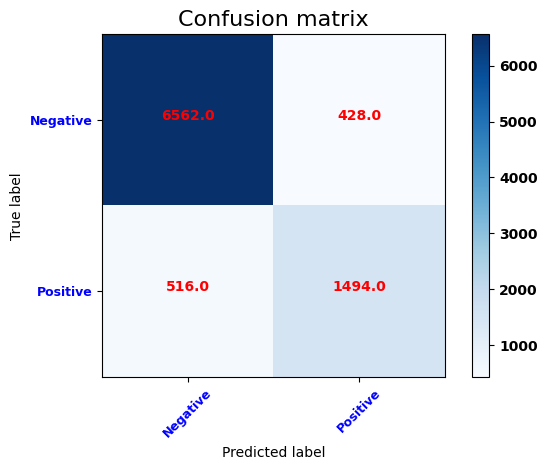

In [34]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.rcParams.update({'font.size': 10})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontdict={'size':'16'})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=9,color="blue")
    plt.yticks(tick_marks, classes,fontsize=9,color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label',fontdict={'size':'10'})
    plt.xlabel('Predicted label',fontdict={'size':'10'})
    plt.tight_layout()

plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=['Negative','Positive'],
                      title='Confusion matrix')

In [21]:
print(f"Classification Report\n\n {classification_report(y_test, y_pred)}")

Classification Report

               precision    recall  f1-score   support

           0       0.93      0.94      0.93      6990
           1       0.78      0.74      0.76      2010

    accuracy                           0.90      9000
   macro avg       0.85      0.84      0.85      9000
weighted avg       0.89      0.90      0.89      9000



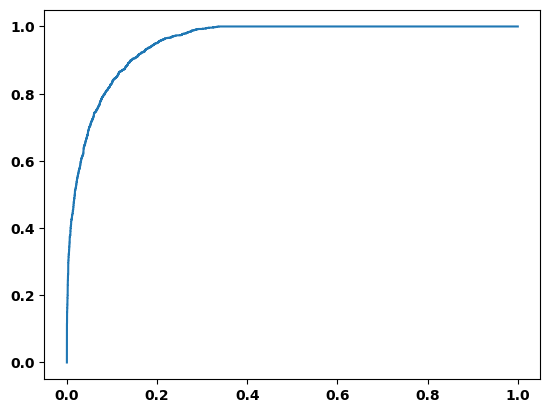

In [39]:
def generate_auc_roc_curve(model, X_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr)
    plt.show()
    pass

generate_auc_roc_curve(model, X_test)

In [38]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC ROC Curve with Area Under the curve = %.3f"%auc)

AUC ROC Curve with Area Under the curve = 0.953


* **While we see high values ​​in those with a loan status of 0,**

 **the results of those with a loan status of 1 are not so good.**

* **Because our data set is an unbalanced data set.**

In [22]:
df['loan_status'].value_counts()

,count
loan_status,
0,35000
1,10000


# Resampling

## Random Oversampling

In [40]:
# Random Oversampling (Only Applyies to Training set)
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
x_train_random, y_train_random = oversampler.fit_resample(X_train, y_train)

y_train_random.value_counts()

,count
loan_status,
0,28010
1,28010


In [43]:
model.fit(x_train_random, y_train_random)
y_pred = model.predict(X_test)
accuracy_ros = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy_ros,2)}")

Accuracy: 0.86


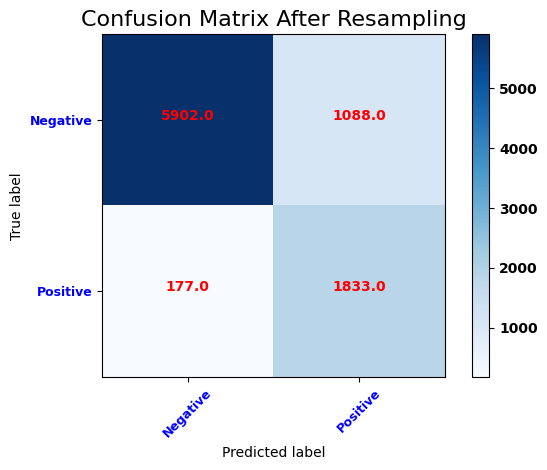

In [44]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred),classes=['Negative','Positive'],
                      title='Confusion Matrix After Resampling')

In [45]:
print(f"Classification Report\n\n {classification_report(y_test, y_pred)}")

Classification Report

               precision    recall  f1-score   support

           0       0.97      0.84      0.90      6990
           1       0.63      0.91      0.74      2010

    accuracy                           0.86      9000
   macro avg       0.80      0.88      0.82      9000
weighted avg       0.89      0.86      0.87      9000



* When looking at the Confusion Matrix and Classification report, the false positive rate of predicted 0 classes seems high,

  which has decreased the precision value of class 1.
  
* But there is also an increase in the **recall value of class 1**,

  and the model's correct prediction rate of the 1 class has increased.
* Compared to the first model, the success of predicting the 0 class has decreased,

  but the increase in the correct prediction of the 1 class is a major factor in our preference for the model created after random oversampling.

## SMOTE Oversampling


In [69]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

y_smote.value_counts()

,count
loan_status,
0,28010
1,28010


In [70]:
model.fit(x_smote, y_smote)
y_pred = model.predict(X_test)
accuracy_smote = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f" % (accuracy_smote))

Accuracy: 0.865


In [62]:
print("Classification Report\n".center(70),"\n",f"{classification_report(y_test, y_pred)}")

                        Classification Report
                         
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      6990
           1       0.64      0.90      0.75      2010

    accuracy                           0.86      9000
   macro avg       0.80      0.88      0.83      9000
weighted avg       0.90      0.86      0.87      9000



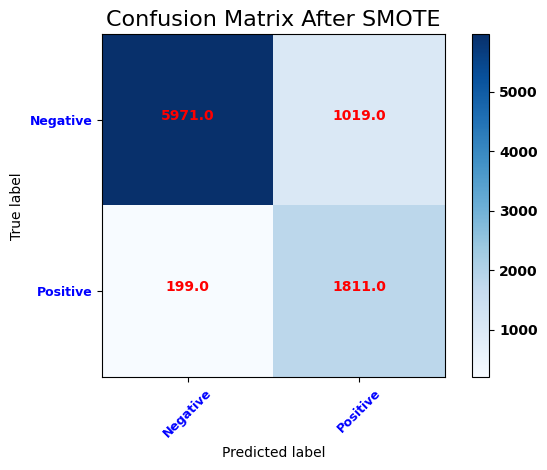

In [71]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred),classes=['Negative','Positive'],
                      title='Confusion Matrix After SMOTE')

## Undersampling

(Used when the dataset is large)

In [65]:
from imblearn.under_sampling import RandomUnderSampler
undersampler  = RandomUnderSampler(sampling_strategy='majority')
x_undersampler, y_undersampler  = undersampler.fit_resample(X_train, y_train)

y_undersampler.value_counts()

,count
loan_status,
0,7990
1,7990


In [66]:
model.fit(x_undersampler, y_undersampler)
y_pred = model.predict(X_test)
accuracu_und = accuracy_score(y_test, y_pred)

In [67]:
print("Classification Report\n".center(70),"\n",f"{classification_report(y_test, y_pred)}")

                        Classification Report
                         
               precision    recall  f1-score   support

           0       0.97      0.84      0.90      6990
           1       0.63      0.91      0.74      2010

    accuracy                           0.86      9000
   macro avg       0.80      0.88      0.82      9000
weighted avg       0.89      0.86      0.87      9000



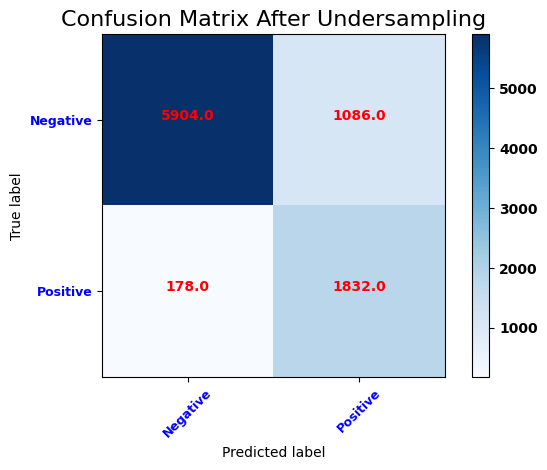

In [68]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred),classes=['Negative','Positive'],
                      title='Confusion Matrix After Undersampling')

# Result

* We used various sampling methods to more accurately estimate the minority class in imbalanced datasets.
* We wanted to increase the **Recall** metric as a priority.
* After **undersampling**, we reached the highest recall value of 0.91.